<center>
    <p style="text-align:center">
        <h1>OpenLLM</h1>
        <img alt="BentoML logo" src="https://raw.githubusercontent.com/bentoml/BentoML/main/docs/source/_static/img/bentoml-logo-black.png" width="200"/>
        </br>
        <a href="https://github.com/bentoml/OpenLLM">GitHub</a>
        |
        <a href="https://l.bentoml.com/join-openllm-discord">Community</a>
    </p>
</center>
<h1 align="center">Serving Llama2 with OpenLLM</h1>

[OpenLLM](https://github.com/bentoml/OpenLLM) is an open-source framework for serving and operating any Large Language Models (LLMs) in production.

This is a project demonstrating basic usage of OpenLLM with
Llama 2 as an example. In this tutorial, you will learn the following:

- Set up your environment to work with OpenLLM.
- Use OpenLLM Python APIs to create a demo.
- Serve LLMs like Llama 2 with just a single command.
- Explore different ways to interact with the OpenLLM server.
- Build bentos for production deployment.

## Set up the environment

You can try this demo in one of the following ways:

1. Via Google Colab.

   We recommend you run this demo on a GPU. To verify if you're using a GPU on Google Colab, check the runtime type in the top left corner.

   To change the runtime type: In the toolbar menu, click **Runtime** > **Change runtime type** > Select the GPU (T4)
   
   Paid users may have access to more advanced GPUs. For free users, the T4 GPU might occasionally be unavailable.

2. (Optional) Run this project locally.

    If you have a GPU, you can also run this notebook locally with:
    
    ```
    git clone git@github.com:bentoml/OpenLLM.git && cd OpenLLM/examples/openllm-llama2-demo && jupyter notebook
    ```

### [Optional] Check GPU and memory resources

In [ ]:
##@title Check the memory and GPU info you have
import psutil
import torch

ram = psutil.virtual_memory()
ram_total = ram.total / (1024 ** 3)
print("MemTotal: %.2f GB" % ram_total)

print("=============GPU INFO=============")
if torch.cuda.is_available():
    !/opt/bin/nvidia-smi || ture
else:
    print("GPU NOT available")

### Install required dependencies

In [ ]:
!pip install -U -q  openllm[llama,vllm] openai langchain
!apt install tensorrt

## Python API demo

You can create a simple demo of serving LLMs quickly by using Openllm runner.
Learn more about Runners in the [BentoML documentation](https://docs.bentoml.com/en/latest/concepts/runner.html).

Firstly, let's initialize an OpenLLM Runner locally.
- Here, we're serving the smallest Llama 2 model, the 7 billion parameter version. You can simply change 7b in the string with 13b or 70b for the larger parameter sizes. but a larger model means larger VRAM
- we recommend you use vLLM as the backend for better performance.


In [ ]:
import openllm
llm_runner = openllm.Runner("llama",  model_id="NousResearch/llama-2-7b-chat-hf", backend='vllm', init_local=True)

You can manually trigger the model download if it is not downloaded automatically.

In [ ]:
llm_runner.download_model()

### Test it with an prompt  

In [ ]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

async def main():
  async for output in llm_runner.vllm_generate.async_stream("what is the weather like in San Francisco?", request_id="testId"):
    print(output[0])

asyncio.run(main())

### Clean up


to clean up, let's destroy runner

In [ ]:
llm_runner.destroy()
del llm_runner

then trigger the gc to release GPU memory

In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

## OpenLLM server demo

### Launch an OpenLLM server

it is quite straightforward to Launch an OpenLLM server. With just a single command
```
openllm start llama --model-id {MODEL_ID} --backend [pt|vllm|...]
```

OpenLLM supports a variety of LLMs and archtiectures. Learn more in https://github.com/bentoml/OpenLLM#-supported-models.

To unblock the following steps, run it in the background via `nohup`:

In [ ]:
!nohup openllm start llama --model-id NousResearch/llama-2-7b-chat-hf --port 8001 --backend vllm > openllm.log 2>&1 &

Check the process you just started.

In [ ]:
! ps aux|grep 'openllm'|grep -v grep

### [IMPORTANT] Server status check

You can check if the server is ready (status code = 200). It may take some time for the server to be up and running.

In [ ]:
! curl -i http://127.0.0.1:8001/readyz

### Interact with the LLM server

Use one of the following ways to access the server.

1. Run the `openllm query` command to query the model:



In [ ]:
!openllm query --endpoint http://127.0.0.1:8001 --timeout 120 "What is the weight of the earth?"

2. if you are in Google Colab, visit the web UI.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    #using colab proxy URL
    from google.colab.output import eval_js
    print("you are in colab runtime. please try it out in %s" % eval_js("google.colab.kernel.proxyPort(8001)"))

3. Use OpenLLM's built-in Python client.

In [ ]:
import openllm

# sync API
client = openllm.client.HTTPClient("http://127.0.0.1:8001", timeout=120)
res = client.query("what is the weight of the earth?", max_new_tokens=8192)

# Async API
# async_client = openllm.client.AsyncHTTPClient("http://127.0.0.1:8001", timeout=120)
# res = await async_client.query("what is the weight of the earth?", max_new_tokens=8192)
print(res.responses[0]['text'])

4. Send a request using `curl`.

In [ ]:
!curl -k -X 'POST' \
  'http://127.0.0.1:8001/v1/generate_stream' \
  -H 'accept: text/event-stream' \
  -H 'Content-Type: application/json' \
  -d '{"prompt":"write a tagline for an ice cream shop\n", "llm_config": {"max_new_tokens": 256}}'

5. Use the OpenAI compatible endpoint.

In [ ]:
import openai
openai.api_base = "http://localhost:8001/v1"
openai.api_key = "na"

response = openai.Completion.create(model="llama2", prompt="Say this is a test")
print(response)

chatCompletion = openai.ChatCompletion.create(
    model="llama2",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello!"}
    ]
)
print(chatCompletion)

#### LangChain integration

OpenLLM supports integration with LangChain. You can use `langchain.llms.OpenLLM` to interact with the remote OpenLLM server. You can connect to it by specifying its URL:


In [ ]:
from langchain.llms import OpenLLM
llm = OpenLLM(server_url="http://localhost:8001")

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

template = "What is a good name for a company that makes {product}?"

prompt = PromptTemplate(template=template, input_variables=["product"])

llm_chain = LLMChain(prompt=prompt, llm=llm)

generated = llm_chain.run(product="mechanical keyboard")
print(generated)

### Stop the server in the background

In [ ]:
!pkill -f 'bentoml|openllm'

## Deploy Llama2 in production with BentoCloud

After you test the server, you can deploy it in production using BentoCloud.

### What is BentoCloud?

[BentoCloud](https://www.bentoml.com/cloud) is a fully-managed platform designed for building and operating AI applications.

  * Easiest way to deploy and operate AI applications.
  * Natively support the OpenLLM workflow and optimization.

If you don't have a BentoCloud account, visit the [BentoCloud website](https://www.bentoml.com/cloud) to start a free trial.


You can follow the steps in these blog posts to deploy your LLM to BentoCloud:

* [llama2-7b](https://www.bentoml.com/blog/deploying-llama-2-7b-on-bentocloud)
* [llama2-13b](https://www.bentoml.com/blog/openllm-in-action-part-2-deploying-llama-2-13b-on-bentocloud)
* [llama2-70b]()

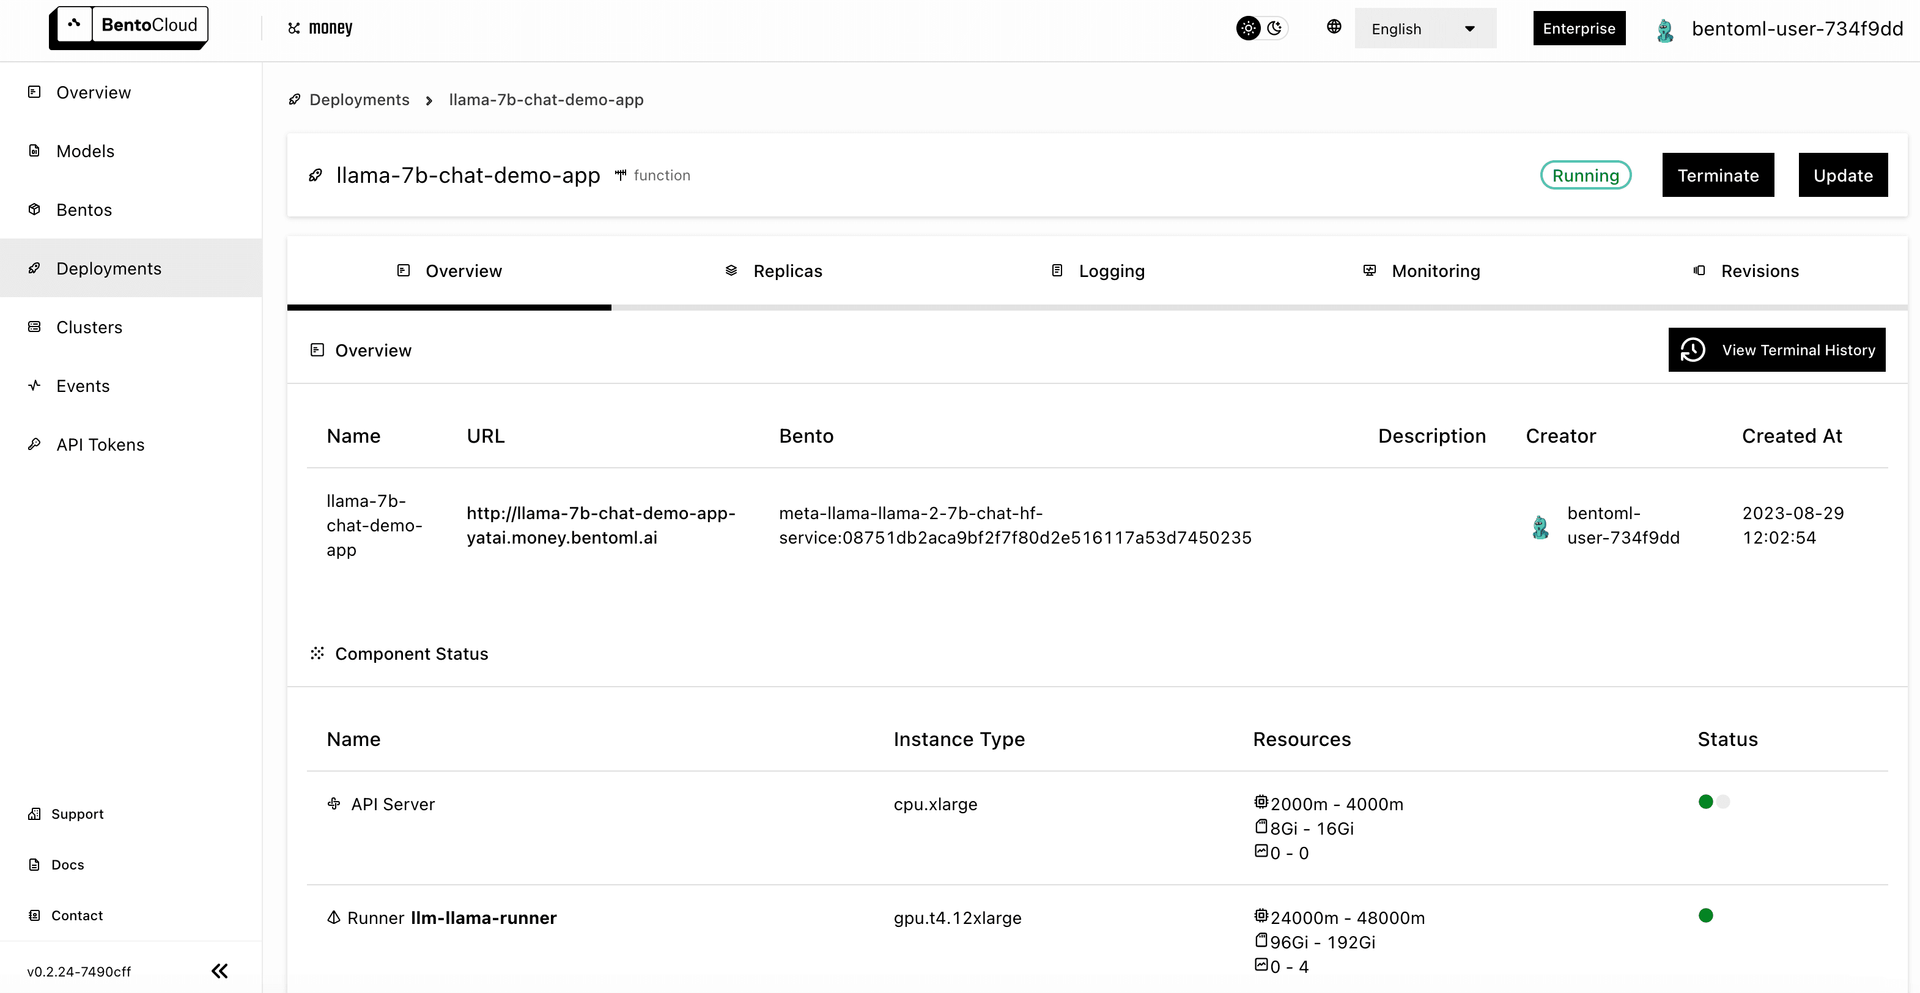

### Build a Bento

Use OpenLLM to build the model into a standardized distribution unit in BentoML, also known as a Bento. Command:

```
openllm build llama --model-id {model-id} --backend [pt|vllm]
```

In [ ]:
!openllm build llama --model-id NousResearch/llama-2-7b-chat-hf --backend vllm

### View the Bento

In [ ]:
!openllm list-bentos

### Log in to BentoCloud and push the Bento

To log in to BentoCloud and push the Bento to it, you need your BentoCloud endpoint URL and an API token. For more information, see [Manage access tokens](https://docs.bentoml.com/en/latest/bentocloud/how-tos/manage-access-token.html).

In [ ]:
return_code = !bentoml cloud list-context

if "colab-user" not in ''.join(return_code):
  # Log in to BentoCloud
  endpoint = input("input endpoint (like https://xxx.cloud.bentoml.com): ")
  token = input("input token (please follow https://docs.bentoml.com/en/latest/bentocloud/how-tos/manage-access-token.html#creating-an-api-token):")
  !bentoml cloud login --api-token {token} --endpoint {endpoint} --context colab-user

# Replace the Bento tag with your own
!bentoml push nousresearch--llama-2-7b-chat-hf-service:37892f30c23786c0d5367d80481fa0d9fba93cf8 --context colab-user

### Create a Deployment via the BentoCloud Console

Follow this [guide](https://www.bentoml.com/blog/deploying-llama-2-7b-on-bentocloud) to deploy this Bento on BentoCloud.

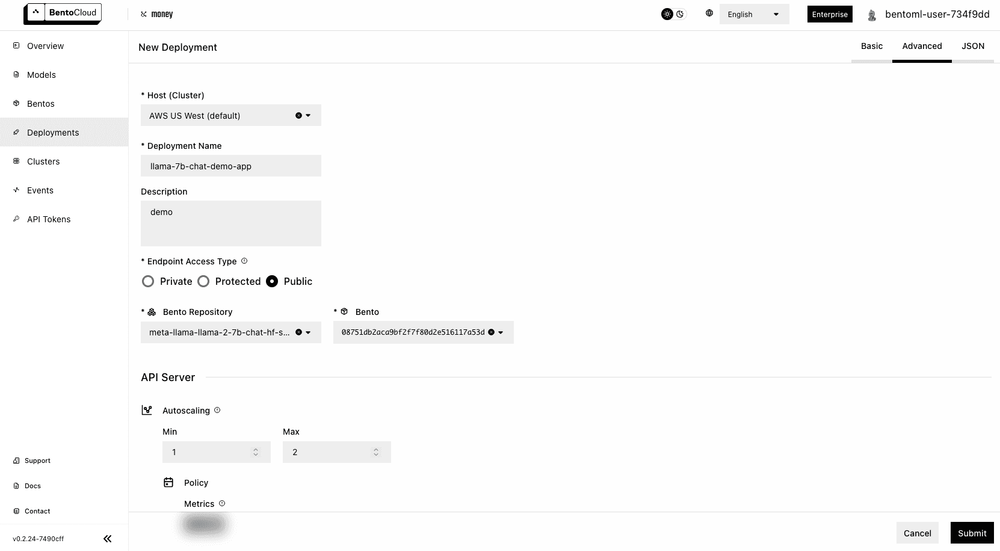

### Create a Deployment via the BentoML client

You can find detailed configuration in [Deployment creation and update information](https://docs.bentoml.com/en/latest/bentocloud/reference/deployment-creation-and-update-info.html).

📢 Make sure you have logged in to BentoCloud in the last step.

In [ ]:
###@title Alternatively, use the BentoML client to create a Deployment.
import bentoml
import json

return_code = !bentoml cloud list-context
if "colab-user" not in ''.join(return_code):
  print("please login first!")
else:
  client = bentoml.cloud.BentoCloudClient()
  #runner config
  runner = bentoml.cloud.Resource.for_runner(
      resource_instance="starter-aws-g4dn-xlarge-gpu-t4-xlarge",
      #hpa_conf={"min_replicas": 1, "max_replicas": 1},
  )
  #api-server hpa config
  api_server = bentoml.cloud.Resource.for_api_server(
      resource_instance="starter-aws-t3-2xlarge-cpu-small",
  )
  hpa_conf = bentoml.cloud.Resource.for_hpa_conf(min_replicas=1, max_replicas=1)

  res = client.deployment.create(
      deployment_name="test-llama2",
      bento="nousresearch--llama-2-7b-chat-hf-service:37892f30c23786c0d5367d80481fa0d9fba93cf8",
      context = "colab-user",
      cluster_name = "default",
      #mode="deployment",
      kube_namespace='yatai',
      runners_config={"llm-llama-runner": runner},
      api_server_config=api_server,
      hpa_conf=hpa_conf,
  )
  print(json.dump(res, indent=4))